In [2]:
!pip install opencv-python tqdm matplotlib numpy ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip3 install tdmclient --upgrade

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, clear_output
import time
import math

In [51]:
def find_camera_index(i):
    cap = cv2.Videocapture(i)
    if cap.isOpened():
        print(f"Camera index {i} found.")
        cap.release()
        return(i)
    else:
        print(f"No camera found at index {i}.")
        return find_camera_index(i+1)

def show_frame(frame):
    _, img_encoded = cv2.imencode('.png', frame)
    IPython.display.display(IPython.display.Image(data=img_encoded.tobytes()))

def vector_to_angle(vector):
    angle = math.atan2(vector[1], vector[0])
    return angle

def upper_lower_color(color_sample, c):
    # Define the upper and lower limit of the color given the sample image 
    mean, stddev = cv2.meanStdDev(color_sample)
    lower_color = mean - c*stddev
    upper_color = mean + c*stddev
    return lower_color, upper_color

def find_contours(frame, color,c):
    lower_b, upper_b = upper_lower_color(color, c)
    # Find contours in the binary mask
    mask = cv2.inRange(frame, lower_b, upper_b)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

class Obj:
    def __init__(self, color_obj, min_size_obj, color_tolerance = 2, img_pos = np.array([[]])):
        self.color_obj = color_obj
        self.min_size_obj = min_size_obj
        self.color_tolerance = color_tolerance
        self.img_pos = img_pos
        self.boundingRect = np.array([[]])
    
    def detect(self, frame):
        contours = find_contours(frame, self.color_obj,self.color_tolerance)
        centroids = []
        sides = []
        for contour in contours:
        # Get the size of the contour
            area = cv2.contourArea(contour)
            # Set a threshold for the contour size to filter out small contours
            if area > self.min_size_obj:
                # Calculate centroid
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    centroids.append([cx, cy])
                    x, y, w, h = cv2.boundingRect(contour)
                    sides.append([x, y, w, h])
        if len(centroids) > 0:
            self.img_pos = np.array(centroids)
            self.boundingRect = np.array(sides)
        return
    
    def get_img_pos(self, frame):
        self.detect(frame)
        return self.img_pos
    
    def get_img_contours(self, frame):
        self.detect(frame)
        return self.boundingRect

    def draw(self, frame, color):
        for p in range(np.size(self.get_img_pos(frame),0)):
            if np.size(self.img_pos[p]) > 0:
                cv2.circle(frame, self.img_pos[p], 5, color, -1)
                if np.size(self.boundingRect[p]) > 0:
                    x,y,w,h = self.boundingRect[p]
                    cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        return

        
class Map:
    def __init__(self, ref1, ref2, ref3, distance_r1r2 = 400, distance_r3r2 = 400):
        self.ref1 = ref1
        self.ref1_pos = np.array([1, 0])
        self.ref2 = ref2
        self.ref2_pos = np.array([0, 0])
        self.ref3 = ref3
        self.ref3_pos = np.array([0, 1])
        self.origin = np.array([0, 0])
        self.distance_r1r2 = distance_r1r2  #[mm]
        self.distance_r3r2 = distance_r3r2  #[mm]
        self.e1 = (self.ref1_pos - self.ref2_pos)/np.linalg.norm(self.ref1_pos - self.ref2_pos)
        self.e2 = (self.ref3_pos - self.ref2_pos)/np.linalg.norm(self.ref3_pos - self.ref2_pos)
        self.scale = np.array([distance_r1r2/np.linalg.norm(self.ref1_pos - self.ref2_pos), distance_r3r2/np.linalg.norm(self.ref3_pos - self.ref2_pos)])
        
    def loc_img2map(self, frame, img_coordinates):
        if np.size(img_coordinates) > 1:
            r1_img_pos = self.ref1.get_img_pos(frame)[0]
            r2_img_pos = self.ref2.get_img_pos(frame)[0]
            r3_img_pos = self.ref3.get_img_pos(frame)[0]
            e1_img = r1_img_pos - r2_img_pos
            e2_img = r3_img_pos - r2_img_pos
            basis = np.array([e1_img,e2_img])
            # Check if the basis vectors form a linearly independent set
            if np.linalg.matrix_rank(basis) != 2:
                return np.array([])
            else:
                map_coordinates = np.linalg.solve(np.transpose(basis), img_coordinates-r2_img_pos)
                return map_coordinates
        else:
            return np.array([])
    
    def vec_img2map(self, frame, img_coordinates):
        if np.size(img_coordinates) > 1:
            r1_img_pos = self.ref1.get_img_pos(frame)[0]
            r2_img_pos = self.ref2.get_img_pos(frame)[0]
            r3_img_pos = self.ref3.get_img_pos(frame)[0]
            e1_img = r1_img_pos - r2_img_pos
            e2_img = r3_img_pos - r2_img_pos
            basis = np.array([e1_img,e2_img])
            # Check if the basis vectors form a linearly independent set
            if np.linalg.matrix_rank(basis) != 2:
                return np.array([])
            else:
                map_coordinates = np.linalg.solve(np.transpose(basis), img_coordinates)
                return map_coordinates
        else:
            return np.array([])
    
    def loc_map2img(self, frame, map_coordinates):
        if np.size(map_coordinates) > 1:
            r1_img_pos = self.ref1.get_img_pos(frame)[0]
            r2_img_pos = self.ref2.get_img_pos(frame)[0]
            r3_img_pos = self.ref3.get_img_pos(frame)[0]
            e1_img = r1_img_pos - r2_img_pos
            e2_img = r3_img_pos - r2_img_pos
            img_coordinates = np.round(r2_img_pos + map_coordinates[0]*e1_img + map_coordinates[1]*e2_img).astype(int)
            return img_coordinates
        else:
            return np.array([])
    
    def localize(self, frame, obj):
        img_coordinates = obj.get_img_pos(frame)
        map_pos = []
        for o in range(len(img_coordinates)):
            map_pos.append(self.loc_img2map(frame, img_coordinates[o]))
        return np.array(map_pos)
    
    def matrix(self, frame, objects, robot, refs):
        # Print the map in a matrix format with the given objects represented as numbers
        square_size = 25 #[mm]
        margins = 4
        origin = np.array([margins, margins])
        matrix = np.zeros([2*margins+self.distance_r1r2//square_size,2*margins+self.distance_r1r2//square_size])
        # Write the obstacles positions in the matrix with a 1
        for o in range(len(objects)):
            map_pos = self.localize(frame,objects[o])
            for p in range(np.size(map_pos,0)):
                if np.size(map_pos[p]) > 0:
                    if not(np.isnan(map_pos[p]).any()):
                        mat_pos = origin + np.round(np.multiply(map_pos[p], np.divide(self.scale,square_size))).astype(int)
                        if mat_pos[0] > 0 and mat_pos[1] > 0 and mat_pos[0] < np.size(matrix,0) and mat_pos[1] < np.size(matrix,1):
                            matrix[mat_pos[0],mat_pos[1]] = 1
                        if np.size(objects[o].boundingRect[p]) > 0:
                            x,y,w,h = objects[o].boundingRect[p]
                            left_top_corner = self.loc_img2map(frame,np.array([x,y]))
                            right_bottom_corner = self.loc_img2map(frame,np.array([x+w,y+h]))
                            mat_l_t_c = origin + np.round(np.multiply(left_top_corner, np.divide(self.scale,square_size))).astype(int)
                            mat_r_b_c = origin + np.round(np.multiply(right_bottom_corner, np.divide(self.scale,square_size))).astype(int)
                            if mat_l_t_c[0] > 0 and mat_l_t_c[1] > 0 and mat_l_t_c[0] < np.size(matrix,0) and mat_l_t_c[1] < np.size(matrix,1):
                                if mat_r_b_c[0] > np.size(matrix,0):
                                    mat_r_b_c[0] = np.size(matrix,0)-1
                                if mat_r_b_c[1] > np.size(matrix,1):
                                    mat_r_b_c[1] = np.size(matrix,1)-1
                                matrix[mat_l_t_c[0]:mat_r_b_c[0], mat_l_t_c[1]:mat_r_b_c[1]] = np.ones([mat_r_b_c[0]-mat_l_t_c[0],mat_r_b_c[1]-mat_l_t_c[1]])
                            else:
                                if mat_r_b_c[0] > 0 and mat_r_b_c[1] > 0 and mat_r_b_c[0] < np.size(matrix,0) and mat_r_b_c[1] < np.size(matrix,1):
                                    if mat_l_t_c[0] < 0:
                                        mat_l_t_c[0] = 0
                                    if mat_l_t_c[1] < 0:
                                        mat_l_t_c[1] = 0
                                    matrix[mat_l_t_c[0]:mat_r_b_c[0], mat_l_t_c[1]:mat_r_b_c[1]] = np.ones([mat_r_b_c[0]-mat_l_t_c[0], mat_r_b_c[1]-mat_l_t_c[1]])
        # Write the robot position in the matrix with a 2
        map_pos = self.localize(frame,robot)[0]
        if np.size(map_pos) > 0:
            if not(np.isnan(map_pos).any()):
                mat_pos = origin + np.round(np.multiply(map_pos, np.divide(self.scale,square_size))).astype(int)
                if mat_pos[0] > 0 and mat_pos[1] > 0 and mat_pos[0] < np.size(matrix,0) and mat_pos[1] < np.size(matrix,1):
                    matrix[mat_pos[0],mat_pos[1]] = 2
        """ # Write the goal position in the matrix with a 3
        map_pos = self.localize(frame,robot)[0]
        if np.size(map_pos) > 0:
            if not(np.isnan(map_pos).any()):
                mat_pos = origin + np.round(np.multiply(map_pos, np.divide(self.scale,square_size))).astype(int)
                if mat_pos[0] > 0 and mat_pos[1] > 0 and mat_pos[0] < np.size(matrix,0) and mat_pos[1] < np.size(matrix,1):
                    matrix[mat_pos[0],mat_pos[1]] = 3 """
        # Write the ref positions in the matrix with a 4
        for o in range(len(refs)):
            map_pos = self.localize(frame,refs[o])
            for p in range(np.size(map_pos,0)):
                if np.size(map_pos[p]) > 0:
                    if not(np.isnan(map_pos[p]).any()):
                        mat_pos = origin + np.round(np.multiply(map_pos[p], np.divide(self.scale,square_size))).astype(int)
                        if mat_pos[0] > 0 and mat_pos[1] > 0 and mat_pos[0] < np.size(matrix,0) and mat_pos[1] < np.size(matrix,1):
                            matrix[mat_pos[0],mat_pos[1]] = 4
        return matrix


class Robot:
    # A robot is defined by a mark on each of its sides left and right.
    # Its position and direction are derived from these two attributes.
    def __init__(self, left_mark, right_mark):
        self.left_mark = left_mark
        self.right_mark = right_mark
        self.img_pos = np.array([[]])
        self.boundingRect = np.array([[]])
        self.img_dir = np.array([[]])

    def detect(self, frame):
        lm_img_pos = self.left_mark.get_img_pos(frame)[0]
        rm_img_pos = self.right_mark.get_img_pos(frame)[0]
        if (np.size(lm_img_pos) > 0) and (np.size(rm_img_pos) > 0):
            self.img_pos = np.array([[(lm_img_pos[0] + rm_img_pos[0])//2, (lm_img_pos[1] + rm_img_pos[1])//2]])
            self.img_dir = np.array([[(lm_img_pos[1] - rm_img_pos[1]), -(lm_img_pos[0] - rm_img_pos[0])]])
            w = np.round(np.linalg.norm(lm_img_pos - rm_img_pos)).astype(int)
            c = 2
            self.boundingRect = np.array([[self.img_pos[0,0]-c*w//2,self.img_pos[0,1]-c*w//2,c*w,c*w]])
        return
    
    def get_img_pos(self, frame):
        self.detect(frame)
        return self.img_pos
    
    def get_img_dir(self, frame):
        self.detect(frame)
        return self.img_dir
    
    def get_img_pos_dir(self, frame):
        self.detect(frame)
        return self.img_pos, self.img_dir
        
    def localize(self, frame, map):
        img_pos, img_dir = self.get_img_pos_dir(frame)
        position = map.loc_img2map(frame, img_pos[0])
        dir = map.vec_img2map(frame, img_dir[0])
        direction = dir/np.linalg.norm(dir)
        return np.array([position, direction])
    
    def draw(self, frame, color):
        self.detect(frame)
        if np.size(self.img_pos[0]) > 0:
            cv2.circle(frame, self.img_pos[0], 5, color, -1)
            cv2.line(frame, self.img_pos[0],np.add(self.img_pos[0],self.img_dir[0]), color, 2)
            if np.size(self.boundingRect[0]) > 0:
                x,y,w,h = self.boundingRect[0]
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        return



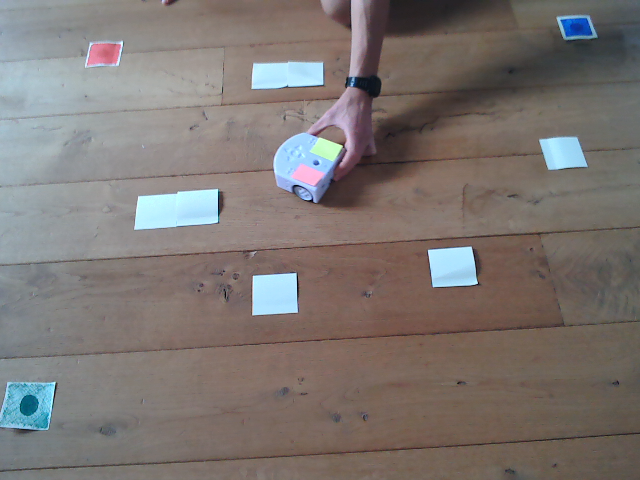

In [96]:
i = 0
cap = cv2.VideoCapture(i)
# Check if camera opened successfully
""" while not cap.isOpened():
    cap = cv2.VideoCapture(i)
    print(f"No camera found at index {i}.")
    i += 1
 """
video_imgs = []
titles = []


for i in range(500):
    ret, frame = cap.read()
    if ret == True:
        video_imgs.append(frame)

        show_frame(frame)
        #time.sleep(1)

        clear_output(wait=True)

frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
   
size = (frame_width, frame_height)
video = cv2.VideoWriter('tes_tracking.avi', cv2.VideoWriter_fourcc(*'MJPG'), 10, size)
for f in range(len(video_imgs)):
    video.write(video_imgs[f])


        

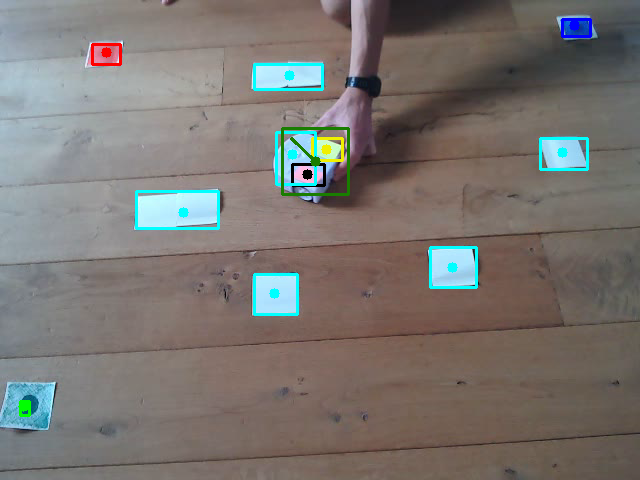

Robot position :  [0.34682527 0.51022756]
Robot direction :  -2.3132080831139614


In [53]:

# Definition of the references used to map the space
color_ref1 = cv2.imread('ref1.jpg')
ref1 = Obj(color_ref1, 50, 2, np.array([[0,0]]))

color_ref2 = cv2.imread('ref2.jpg')
ref2 = Obj(color_ref2, 50, 2, np.array([[0,0]]))

color_ref3 = cv2.imread('ref3.jpg')
ref3 = Obj(color_ref3, 50, 2, np.array([[0,0]]))

map = Map(ref1, ref2, ref3)

# Definition of the objects to recognize in the space
color_obstacle = cv2.imread('obstacle.jpg')
obstacle = Obj(color_obstacle, 600, 3)

color_left_mark = cv2.imread('left_mark.jpg')
left_mark = Obj(color_left_mark, 50, 6)

color_right_mark = cv2.imread('right_mark.jpg')
right_mark = Obj(color_right_mark, 50, 3)

thymio = Robot(right_mark, left_mark)

# the objects to draw on the map in the matrix format
objects = [obstacle]
refs = [ref1, ref2, ref3]

# Open the video
video = cv2.VideoCapture('test2_tracking.avi')
if (video.isOpened()== False): 
  print("Error opening video stream or file")

while(video.isOpened()):
    # Capture frame-by-frame
    ret, frame = video.read()
    if ret == True:
        
        # Draw the objects on a copy of the frame 
        copy_f = frame.copy()
        ref1.draw(copy_f,(0, 255, 0))
        ref2.draw(copy_f,(0,0,255))
        ref3.draw(copy_f,(255, 0, 0))
        left_mark.draw(copy_f,(0, 0, 0))
        right_mark.draw(copy_f,(0, 240, 240))
        obstacle.draw(copy_f, (255, 255, 0))
        thymio.draw(copy_f, (0, 125, 25))
        #show_frame(frame)
        show_frame(copy_f)

        # Print the map in a matrix format
        #print(map.matrix(frame, objects, thymio, refs))
        if np.size(thymio.localize(frame,map)[1], 0) > 0:
          print('Robot position : ', thymio.localize(frame,map)[0])
          print('Robot direction : ', vector_to_angle(thymio.localize(frame,map)[1]))

        #time.sleep(0.01)

        clear_output(wait=True)
    
 
  # Break the loop
    else: 
        break


# When everything done, release the video capture object
video.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [150]:
cv2.imwrite('objects.jpg',video_imgs[40])

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:1113: error: (-215:Assertion failed) !image.empty() in function 'cv::imencode'
